## Read Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Extract Data

In [2]:

## 2019

# read csv files
q1_19 = pd.read_csv('jul_2019_snap/LoanStats_2016Q1_jul19.csv',skiprows=1,skipfooter=2, engine='python')
q2_19 = pd.read_csv('jul_2019_snap/LoanStats_2016Q2_jul19.csv',skiprows=1,skipfooter=2, engine='python')
q3_19 = pd.read_csv('jul_2019_snap/LoanStats_2016Q3_jul19.csv',skiprows=1,skipfooter=2, engine='python')
q4_19 = pd.read_csv('jul_2019_snap/LoanStats_2016Q4_jul19.csv',skiprows=1,skipfooter=2, engine='python')

# concatenate dataframes
p2p_19 = pd.concat([q1_19, q2_19, q3_19, q4_19], ignore_index=True)
df_19 = p2p_19.copy()

# sort values and reset index
df_19 = df_19.sort_values('id').reset_index(drop =True)


##2018

# read csv files
q1_18 = pd.read_csv('apr_2018_snap/LoanStats_2016Q1_apr18.csv',skiprows=1,skipfooter=2, engine='python')
q2_18 = pd.read_csv('apr_2018_snap/LoanStats_2016Q2_apr18.csv',skiprows=1,skipfooter=2, engine='python')
q3_18 = pd.read_csv('apr_2018_snap/LoanStats_2016Q3_apr18.csv',skiprows=1,skipfooter=2, engine='python')
q4_18 = pd.read_csv('apr_2018_snap/LoanStats_2016Q4_apr18.csv',skiprows=1,skipfooter=2, engine='python')

# concatenate dataframes
p2p_18 = pd.concat([q1_18, q2_18, q3_18, q4_18], ignore_index=True)
df_18 = p2p_18.copy()

# sort values and reset index
df_18 = df_18.sort_values('id').reset_index(drop =True)

## Parse Features 
* Rate, Date, Term

In [3]:
for df in [df_18, df_19]:
    #parse rates
    df['int_rate'] = df['int_rate'].str.replace('%', '').astype(float) / 100
    df['revol_util'] = df['revol_util'].str.replace('%', '').astype(float) / 100

    #parse term
    df['term'] = df['term'].str.replace(' months', '').astype(int)

    # parse dates
    def convert_to_datetime(x):
        if pd.isna(x):
            return x
        else:
            return datetime.strptime(x, '%b-%Y')

    df['issue_d'] = df['issue_d'].apply(convert_to_datetime)
    df['last_pymnt_d'] = df['last_pymnt_d'].apply(convert_to_datetime)
#     df['last_credit_pull_d'] = df['last_credit_pull_d'].apply(convert_to_datetime)
#     df['earliest_cr_line'] = df['earliest_cr_line'].apply(convert_to_datetime)
#     df['next_pymnt_d'] = df['next_pymnt_d'].apply(convert_to_datetime)


## Data preprocessing
### Drop Columns

In [4]:
from scipy.stats import entropy

# obviously
columns_to_drop = ['id','url']

#Full of Na - drop columns with more then 40% Na's
na_crit = 0.4

for col in df_19.columns:
    prop = df_19[col].isna().sum()/len(df_19)
    if prop > na_crit:
        columns_to_drop.append(col)
        
# low entropy 
ent_crit = 0.005

for col in df_19.columns:
    
    # Count the frequency of each value
    counts = df[col].value_counts()
    
    # Calculate the proportion of each value
    proportions = counts / len(df)
    
    # Calculate entropy
    ent = entropy(proportions)
    
    # Append entropy to the list
    if ent < ent_crit:
        columns_to_drop.append(col)



In [5]:
columns_to_drop

['id',
 'url',
 'member_id',
 'desc',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'next_pymnt_d',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_revol_delinq',
 'revol_bal_joint',
 'sec_app_fico_range_low',
 'sec_app_fico_range_high',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_open_act_il',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'deferral_term',
 'hardship_amount',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_length',
 'hardship_dpd',
 'hardship_loan_status',
 'orig_projected_additional_accrued_interest',
 'hardship_payoff_balance_amount',
 'hardship_last_payment_amount',
 'debt_settlement_fla

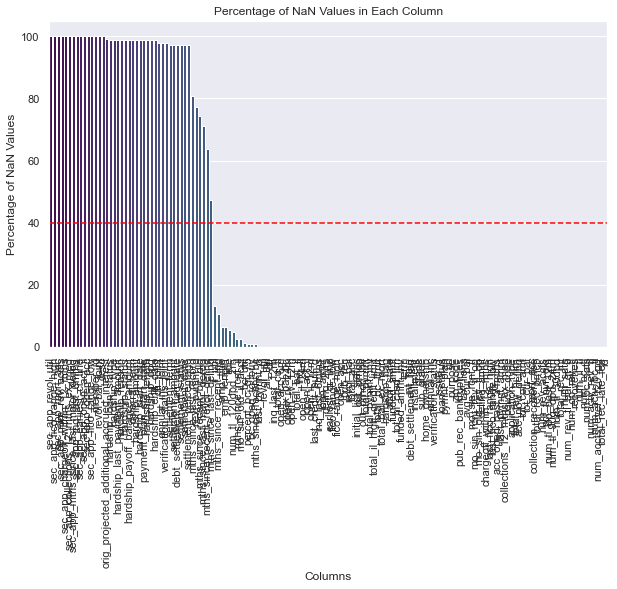

In [6]:
nan_percentages = df_19.isna().mean().sort_values(ascending=False) * 100

# Set the figure size
sns.set(rc={'figure.figsize':(10, 6)})

# Create a bar chart using Seaborn
ax = sns.barplot(x=nan_percentages.index, y=nan_percentages, palette='viridis')

# Add a horizontal dashed red line at the 40th percentile
plt.axhline(y=40, color='red', linestyle='--')

# Rotate the x-axis labels
plt.xticks(rotation=90)

# Set the title and labels
plt.title("Percentage of NaN Values in Each Column")
plt.xlabel("Columns")
plt.ylabel("Percentage of NaN Values")

# Display the plot
plt.show()

#plt.savefig('nan_percentages_bar_chart.png', dpi=300, bbox_inches='tight')



* The `dti` feature provides valuable insight into a borrower's ability to repay the loan, as it takes into account their debt and income levels. Consequently, we will drop the following columns that are already represented in the dti:
    * revol_bal
    * total_bal_il
    * tot_cur_bal
    * total_rev_hi_lim
    * avg_cur_bal
    * total_bal_ex_mort
 
-----
* Included in `total_pymnt`:
    * Drop `recoveries`
------
* Ignore `total_rec_late_fee` and `collection_recovery_fee`
-------
* Drop `installment` due to redundancy with loan amount and interest rate
----
* won't use `zip_code` in our analysis
-----
* Drop `emp_title` it has ~120k unique values
-----
* Drop `Num_tl_120dpd_2m` has another representetive
-----
* Drop `emp_title` it has ~120k unique values
-----
* Drop `num_tl_30dpd` -Has another representative
-----
* Drop `Total_il_high_credit_limit`- represented in tot_hi_cred_lim


In [7]:
# emp_title
df_19['emp_title'].nunique()

121663

In [8]:
# Business Reson
columns_to_drop = columns_to_drop + ['revol_bal', 'total_bal_il', 'tot_cur_bal',
                                     'total_rev_hi_lim', 'avg_cur_bal', 'total_bal_ex_mort',
                                     'recoveries',
                                     'collection_recovery_fee','total_rec_late_fee',
                                     'installment', 'zip_code',
                                     'emp_title','num_tl_30dpd','num_tl_120dpd_2m','total_il_high_credit_limit']


# in case we consider column twice
columns_to_drop = list(set(columns_to_drop))


In [9]:
df_18.drop(columns_to_drop,axis =1, inplace=True)
df_19.drop(columns_to_drop,axis =1, inplace=True)

Some columns are updated as the loan progresses. We will identify and address these columns to ensure accurate analysis.

Initially, we will drop the column present in the 2018 snapshot but not in the 2019 snapshot. This will enable us to effectively compare both snapshots, and we will address this specific column later in our analysis.

In [10]:
eda_df = df_19

In [11]:
set(df_18.columns) - set(df_19.columns)

{'disbursement_method'}

In [12]:
dis_method = df_18['disbursement_method']
df_18.drop('disbursement_method',axis=1,inplace=True)

In [13]:
# dictionries 
equal_cols = {}
non_match_columns = {}
similar_cols = {}


# We will drop columns with less then 45% match 
for col in list(df_18.columns):
    equal_values = (df_18[col] == df_19[col]).sum()
    total_values = len(df_19[col])
    percent_equal = 100 * equal_values / total_values
    
    if percent_equal < 45:
        non_match_columns.update({col:percent_equal})
        
    elif percent_equal == 100:
        equal_cols.update({col:percent_equal})
        
    else:
        similar_cols.update({col:percent_equal})

## Significantly Different Columns Between 2018 and 2019 Snapshots

In [14]:
non_match_columns

{'out_prncp': 39.95653845357004,
 'out_prncp_inv': 39.95653845357004,
 'total_pymnt': 37.458650528191306,
 'total_pymnt_inv': 37.47430405126989,
 'total_rec_prncp': 42.27556185788903,
 'total_rec_int': 42.0980785300421,
 'last_pymnt_d': 42.627535928288445,
 'last_credit_pull_d': 16.0296680302113,
 'last_fico_range_high': 21.91608330436664,
 'last_fico_range_low': 21.91608330436664}

second, we will drop columns which has less than 0.45 similarity between both snapshots

In [15]:
# we need last_pymnt_d and total_pymnt in order to calculate the realized return so we will leave it right now

more_col_to_drop = list(set(non_match_columns.keys()) - set(['total_pymnt','last_pymnt_d']))
eda_df.drop(more_col_to_drop,axis =1, inplace=True)

altough its similar in more the 45% we will remove `last_pymnt_amnt` as we know the feature updated as the loan progresses

In [16]:
print('last_pymnt_amnt - similarity',similar_cols['last_pymnt_amnt'])

#drop column
eda_df.drop('last_pymnt_amnt',axis =1, inplace=True)

last_pymnt_amnt - similarity 66.9648509347225


## Matching Columns Between 2018 and 2019 Snapshots - Data leakage

Next we will drop columns that are highly correlated with other columns:

* `loan_amnt` higlhly correlated with:
    * `funded_amnt` 
    * `funded_amnt_inv` 
---------------------

* `pub_rec` higlhly correlated with (inculded):
    * `pub_rec_bankruptcies`
    * `tax_liens`

In [17]:
display(df_19[['loan_amnt','funded_amnt','funded_amnt_inv']].corr()[['loan_amnt']])
print('----------------------------------')
display(df_19[['pub_rec_bankruptcies','pub_rec','tax_liens']].corr()[['pub_rec']])

,loan_amnt
loan_amnt,1.000000
funded_amnt,0.999996
funded_amnt_inv,0.999988


----------------------------------


,pub_rec
pub_rec_bankruptcies,0.602451
pub_rec,1.000000
tax_liens,0.728626


* The `open_acc` feature serves as a measure of the total number of accounts a borrower holds, encompassing credit cards, installment loans, and revolving accounts. Therefore, we will drop the following columns:
    * num_sats
    * num_op_rev_tl
    * total_acc
    * num_rev_accts
    * num_rev_tl_bal_gt_0
    * num_actv_rev_tl
    * num_bc_sats
    * num_actv_bc_tl
    * num_bc_tl
    * num_tl_op_past_12m

In [18]:
columns_to_drop = ['funded_amnt', 'funded_amnt_inv', 'pub_rec_bankruptcies', 'tax_liens', 'num_sats',
                   'num_op_rev_tl', 'total_acc', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_actv_rev_tl',
                   'num_bc_sats', 'num_actv_bc_tl', 'num_bc_tl', 'num_tl_op_past_12m']

eda_df.drop(columns_to_drop,axis =1, inplace=True)

### Fico

We observe that the FICO range difference is consistently 4 in the majority of cases, with a small portion having a difference of 5. To simplify our analysis, we will create a new column representing the mean FICO score.
* `fico_score` = (`fico_range_high` + `fico_range_low`) / 2

In [19]:
fico_diff = df_19['fico_range_high'] - df['fico_range_low']

fico_diff.value_counts()


4    434339
5        68
dtype: int64

In [20]:
# create new fico_score columns
eda_df['fico_score'] = (eda_df['fico_range_high'] + eda_df['fico_range_low']) / 2

# drop fico range columns
eda_df.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

## Slightly Different Columns Between 2018 and 2019 Snapshots

### emp_length

We will fill missing values with 0, as it likely represents unemployment. We also found that the emp_title feature is missing for the same borrowers, which further supports this assumption.

In [21]:
eda_df['emp_length'].fillna(0, inplace=True)

Open_acc_6m - the mode is 0 , replacing na with the mode value

In [22]:
eda_df['open_acc_6m'].fillna(0, inplace=True)

### Filling NA with median

In [23]:
#fill nas in median
bc_util_median = df_19['bc_util'].median()

# Fill in the missing values in the
df_19['bc_util'].fillna(bc_util_median, inplace=True)
df_18['bc_util'].fillna(bc_util_median, inplace=True)

In [24]:
#fill nas in median
inq_last_12m_median = df_19['inq_last_12m'].median()
# Fill in the missing values in the
eda_df['inq_last_12m'].fillna(inq_last_12m_median, inplace=True)

In [25]:
#fill nas in median
bc_open_to_buy_median = df_19['bc_open_to_buy'].median()

# Fill in the missing values in the
eda_df['bc_open_to_buy'].fillna(bc_open_to_buy_median, inplace=True)


In [26]:
#fill nas in median
max_bal_bc_median = df_19['max_bal_bc'].median()

# Fill in the missing values in the
eda_df['max_bal_bc'].fillna(max_bal_bc_median, inplace=True)


In [27]:
#fill nas in median
all_util_median = df_19['all_util'].median()

# Fill in the missing values 
eda_df['all_util'].fillna(all_util_median, inplace=True)

In [28]:
#fill nas in median
mo_sin_old_il_acct_median = df_19['mo_sin_old_il_acct'].median()

# Fill in the missing values 
eda_df['mo_sin_old_il_acct'].fillna(mo_sin_old_il_acct_median, inplace=True)

In [29]:
#fill nas in median
revol_util_median = df_19['revol_util'].median()

# Fill in the missing values 
eda_df['revol_util'].fillna(revol_util_median, inplace=True)

In [30]:
#fill nas in median
open_act_il_median = df_19['open_act_il'].median()

# Fill in the missing values 
eda_df['open_act_il'].fillna(open_act_il_median, inplace=True)

In [31]:
#fill nas in median
max_bal_bc_median = df_19['max_bal_bc'].median()

# Fill in the missing values 
eda_df['max_bal_bc'].fillna(max_bal_bc_median, inplace=True)

In [32]:
#fill nas in median
all_util_median = df_19['all_util'].median()

# Fill in the missing values 
eda_df['all_util'].fillna(all_util_median, inplace=True)

In [33]:
#fill nas in median
inq_fi_median = df_19['inq_fi'].median()

# Fill in the missing values 
eda_df['inq_fi'].fillna(inq_fi_median, inplace=True)

In [34]:
#fill nas in median
inq_last_6mths_median = df_19['inq_last_6mths'].median()

# Fill in the missing values 
eda_df['inq_last_6mths'].fillna(inq_last_6mths_median, inplace=True)

In [35]:
#fill nas in median
total_cu_tl_median = df_19['total_cu_tl'].median()

# Fill in the missing values 
eda_df['total_cu_tl'].fillna(total_cu_tl_median, inplace=True)

### verification_status

Based on the loan verification status, we found that there were some cases where loans were not verified in 2018 but were source verified in 2019. To avoid data leakage and maintain consistency, we will consider the earlier status as it reflects the verification status at the time of the loan issuance. This will ensure that our analysis is based on accurate and consistent data.

In [36]:
eda_df['verification_status'] = df_18['verification_status']

### intrest rate

Interest rates should not differ since they are set at the beginning of the loan, so we will remove loans with differences below 0.02% as these are likely errors.

In [37]:
# less than 0.02%
print("similarity of int_rate - ", similar_cols['int_rate'])

eda_df = eda_df[df_18['int_rate'] == df_19['int_rate']]

similarity of int_rate -  99.98020289728296


### dti

We will drop 63 loans with missing values in dti

In [38]:
eda_df = eda_df[eda_df['dti'].notna()]

### Title

In [39]:
#fill na to other
df_18['title'] = df_18['title'].fillna("Other")
df_19['title'] = df_19['title'].fillna("Other")

### Other Features

* We have noticed that some features such as installment and revol indicate the account's activity in the last 12 or 24 months. However, we are unsure if these columns represent the same information as at the beginning of the loan or if they are updated later. so we will drop these columns and if needed will be added after initial model building 

In [40]:
# drop 12m columns
eda_df.drop(['open_rv_12m','open_rv_12m','delinq_2yrs',
             'inq_last_6mths','collections_12_mths_ex_med','open_il_12m',
             'open_il_24m', 'mths_since_rcnt_il','open_acc_6m', 'open_act_il',
             'open_rv_24m','inq_last_12m','acc_open_past_24mths','chargeoff_within_12_mths', 'mo_sin_old_il_acct',
             'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc',
             'mths_since_recent_inq','num_accts_ever_120_pd','num_tl_90g_dpd_24m',
             'acc_now_delinq','open_acc','mort_acc','num_il_tl','pct_tl_nvr_dlq','inq_fi',
             'total_cu_tl','debt_settlement_flag','earliest_cr_line'], axis =1 , inplace=True)

#### Loan Status


In [41]:
eda_df['loan_status'] = eda_df['loan_status'].replace({
    'Fully Paid': 'Fully Paid',
    'Charged Off': 'Charged Off',
    'Current': 'Current',
    'In Grace Period': 'Late',
    'Late (31-120 days)': 'Late',
    'Late (16-30 days)': 'Late',
    'Default': 'Charged Off'
})

### More

these columns are highly chance to be data leakage. as we dont know when does the column 

We need to conduct further investigation to determine whether to include other columns or not. In the meantime, let's explore the data that we have.

### Add the column appear in 2018

In [42]:
# adding disbursement method
eda_df['disbursement_method'] = dis_method

## Calculate realized return

### Add columns
* `'months_passed'` - actual month passed from issue date to last payment
* `'ann_realized_return'` - annual realized return

In [43]:
# Define a function to calculate the actual term in months for a single row
def calc_actual_term(row):
    if pd.isna(row['last_pymnt_d']) or row['loan_status'] not in ['Fully Paid', 'Charged Off']:
        return pd.NA
    else:
        return (row['last_pymnt_d'].year - row['issue_d'].year) * 12 + row['last_pymnt_d'].month - row['issue_d'].month

# Apply the function to create the months_passed column
eda_df['months_passed'] = eda_df.apply(lambda row: calc_actual_term(row), axis=1)

In [44]:
eda_df.loc[eda_df['months_passed'] == 0, 'months_passed'] = 1

we will adress loans that paid at the same month as they paid after 1 month

In [45]:
def calc_annual_realized_return(row, i=0.0016515):
    if pd.isna(row['total_pymnt']) or pd.isna(row['months_passed']) or row['loan_status'] not in ['Fully Paid', 'Charged Off']: 
        return pd.NA
    else:
        T = row['term']
        m = row['months_passed']
        p = row['total_pymnt']
        f = row['loan_amnt']   
        num = (p/m) * ((1-(1+i)**(m))/(1-(1+i))) * (1+i)**(T-m)
        den = (12/T) * (1/f)
        annual_return = den * (num - f)
        return annual_return

# Apply the function to create the ann_realized_return column
eda_df['ann_realized_return'] = eda_df.apply(lambda row: calc_annual_realized_return(row), axis=1)

### EDA - Visualization 

In [46]:
new_loan_df = eda_df

In [47]:
## Distribution of some key features

def show_dist(col,mult = 1):
    sns.set(font_scale=2)
    fig, axes = plt.subplots(1, 2,figsize=(30,10),dpi=50)
    sns.boxplot(ax=axes[0], x=new_loan_df[col]*mult)
    axes[0].set_title(col +" distribution")

    sns.histplot(ax=axes[1], x=new_loan_df[col],kde=True)
    axes[1].set_title(col +" distribution and density")
    
    plt.show()

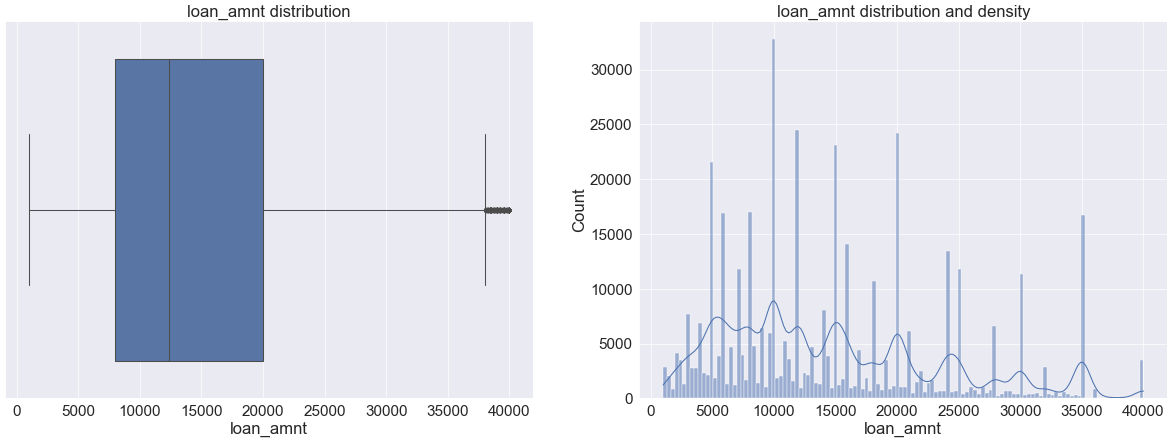

In [48]:
### loan amount 

show_dist('loan_amnt')

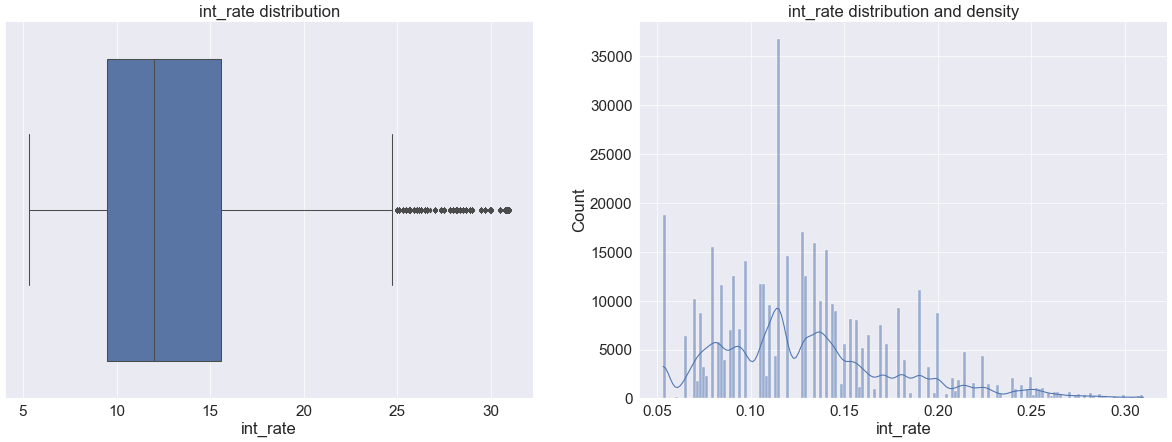

In [49]:
### intrest rate

show_dist('int_rate', 100)

### dti

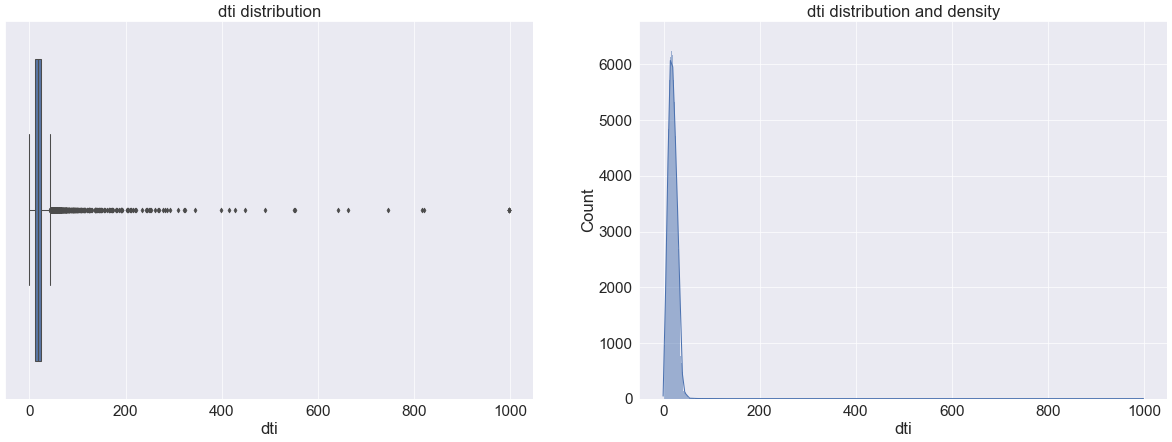

In [50]:
show_dist('dti')

annual income

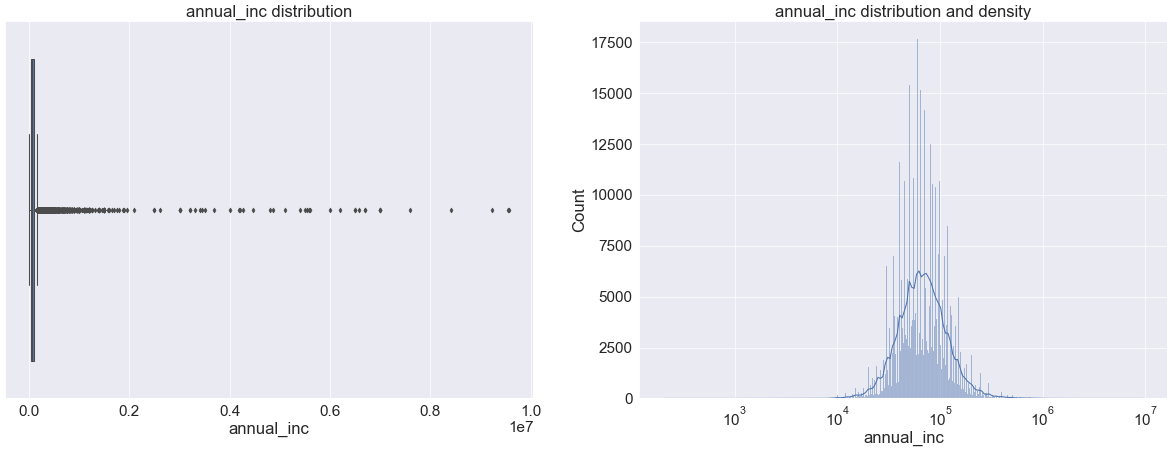

In [51]:
### annual income

sns.set(font_scale=2)
fig, axes = plt.subplots(1, 2,figsize=(30,10),dpi=50)
sns.boxplot(ax=axes[0], x=new_loan_df['annual_inc'])
axes[0].set_title('annual_inc' +" distribution")
plt.xscale('log')

sns.histplot(ax=axes[1], x=new_loan_df['annual_inc'],kde=True)
axes[1].set_title('annual_inc' +" distribution and density")
plt.xscale('log')

plt.show()


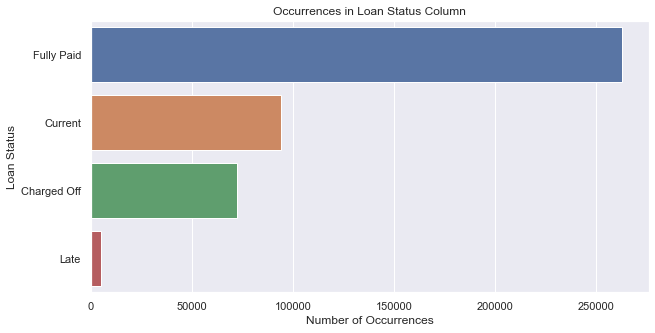

In [52]:
sns.set(font_scale=1)
loan_status_counts = new_loan_df['loan_status'].value_counts().reset_index()

# Rename columns for clarity
loan_status_counts.columns = ['loan_status', 'count']

# Create a horizontal bar chart using seaborn
plt.figure(figsize=(10, 5))
sns.barplot(x='count', y='loan_status', data=loan_status_counts)

# Set axis labels and chart title
plt.xlabel('Number of Occurrences')
plt.ylabel('Loan Status')
plt.title('Occurrences in Loan Status Column')

# Display the chart
plt.show()

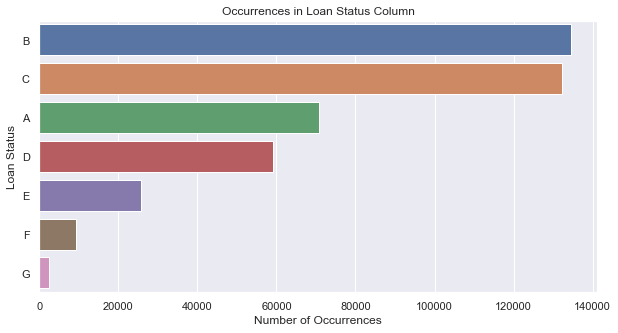

In [53]:
### grade

sns.set(font_scale=1)
loan_status_counts = new_loan_df['grade'].value_counts().reset_index()

# Rename columns for clarity
loan_status_counts.columns = ['grade', 'count']

# Create a horizontal bar chart using seaborn
plt.figure(figsize=(10, 5))
sns.barplot(x='count', y='grade', data=loan_status_counts)

# Set axis labels and chart title
plt.xlabel('Number of Occurrences')
plt.ylabel('Loan Status')
plt.title('Occurrences in Loan Status Column')

# Display the chart
plt.show()

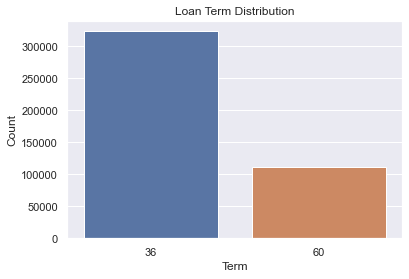

In [54]:
plt.figure(figsize=(6, 4))
sns.countplot(x='term', data=eda_df)
plt.title('Loan Term Distribution')
plt.xlabel('Term')
plt.ylabel('Count')
plt.show()


## int rate VS realized return

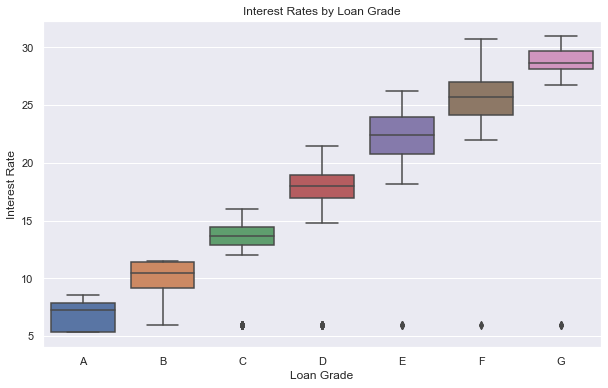

In [55]:
#Annual int interest
plt.figure(figsize=(10,6))
sns.boxplot(x=new_loan_df['grade'], y=new_loan_df['int_rate']*100,
            order= ['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.xlabel('Loan Grade')
plt.ylabel('Interest Rate')
plt.title('Interest Rates by Loan Grade')
plt.show()


Text(0.5, 1.0, 'Annual Realized Return by Grade')

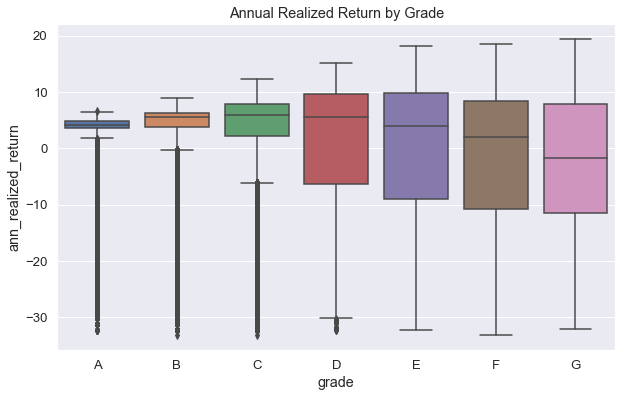

In [56]:
# realized return
plt.figure(figsize=(10,6))
sns.set(font_scale=1.2)
sns.boxplot(x=eda_df.dropna(subset=['ann_realized_return'])['grade'],
                            y=eda_df.dropna(subset=['ann_realized_return'])['ann_realized_return']*100,
                            order= ['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.title('Annual Realized Return by Grade')

In [57]:

# Calculate the mean values for each grade
mean_values = new_loan_df.dropna(subset=['ann_realized_return']).groupby('grade')['ann_realized_return'].mean()

pd.DataFrame((mean_values*100).apply(lambda x: f'{x:.2f}%'))

,ann_realized_return
grade,
A,3.15%
B,2.85%
C,2.06%
D,1.24%
E,0.39%
F,-1.04%
G,-1.65%


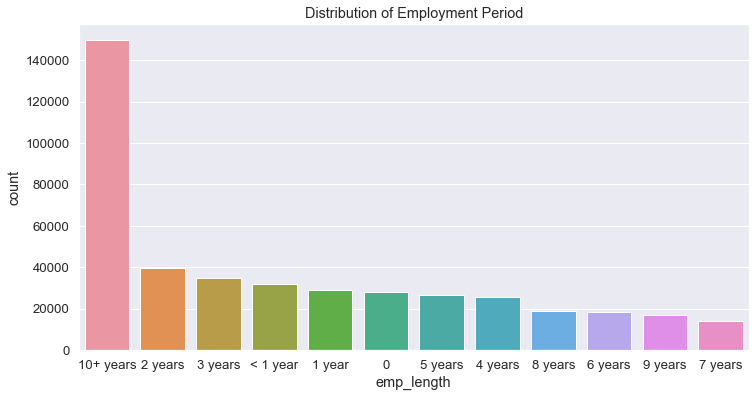

In [58]:
#emp_length Bar chart
emp_length_order = eda_df['emp_length'].value_counts().index.tolist()

plt.figure(figsize=(12,6))
plt.title('Distribution of Employment Period')
sns.countplot(eda_df.emp_length, order=emp_length_order)
plt.show()


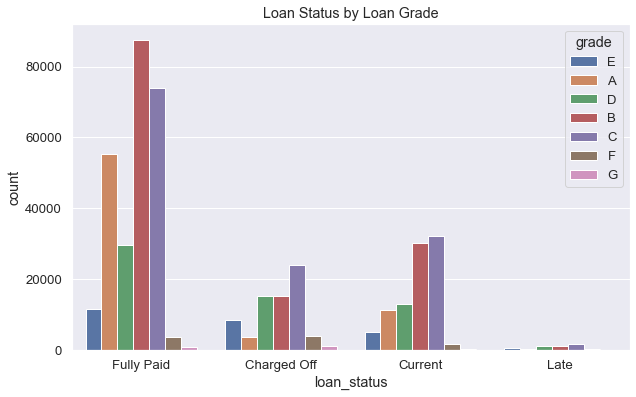

In [59]:
# Loan status countplot by loan grade
plt.figure(figsize=(10,6))
plt.title('Loan Status by Loan Grade')
sns.countplot(data=eda_df, x='loan_status', hue='grade')
plt.show()


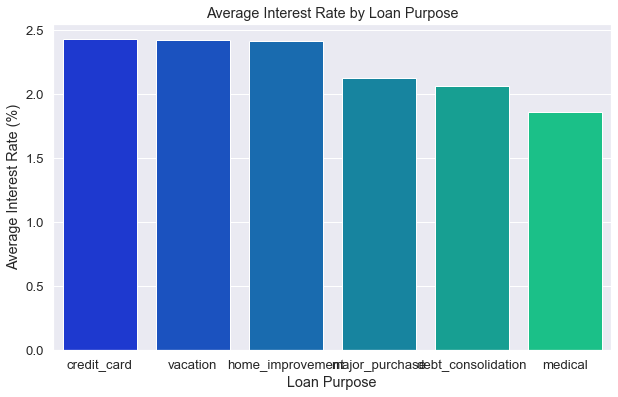

In [60]:
major_purposes=['debt_consolidation','credit_card','home_improvement','medical','vacation','major_purchase']
purpose_major_df = new_loan_df[new_loan_df['purpose'].isin(major_purposes)] 
purpose_major = purpose_major_df[['purpose','ann_realized_return']]
purpose_major_avg = purpose_major.groupby('purpose')['ann_realized_return'].mean()
purpose_major_avg = purpose_major_avg * 100
purpose_major_avg = purpose_major_avg.sort_values(ascending = False)

plt.figure(figsize=(10, 6))
sns.barplot(x=purpose_major_avg.index, y=purpose_major_avg.values, palette='winter')
plt.xlabel('Loan Purpose')
plt.ylabel('Average Interest Rate (%)')
plt.title('Average Interest Rate by Loan Purpose')
plt.show()


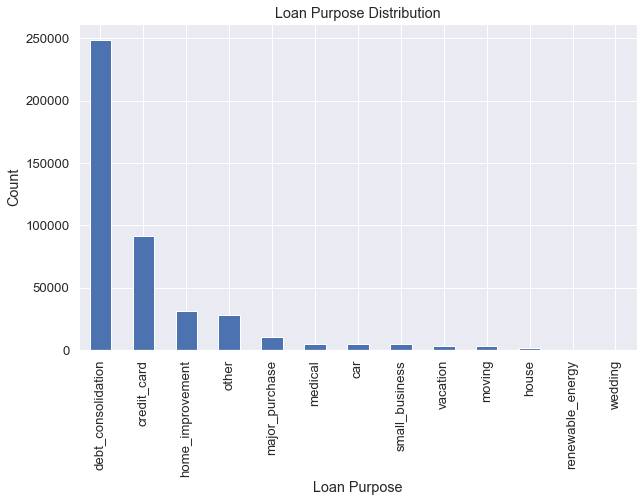

In [61]:
plt.figure(figsize=(10, 6))
loan_purpose_counts = new_loan_df['purpose'].value_counts()
loan_purpose_counts.plot(kind='bar')
plt.xlabel('Loan Purpose')
plt.ylabel('Count')
plt.title('Loan Purpose Distribution')
plt.show()


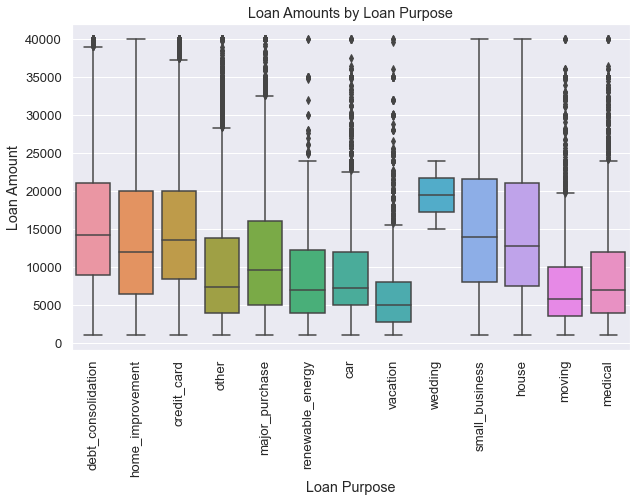

In [62]:
# loan amnt/ purpose
sns.boxplot(x='purpose', y='loan_amnt', data=new_loan_df)
plt.xlabel('Loan Purpose')
plt.ylabel('Loan Amount')
plt.title('Loan Amounts by Loan Purpose')
plt.xticks(rotation=90)
plt.show()


### EDA - Statistics

In [63]:
#Purpose Counter
purpose_count = df.groupby('purpose')['purpose'].count()
purpose_count.sort_values(ascending = False)

purpose
debt_consolidation    248899
credit_card            91609
home_improvement       31182
other                  28469
major_purchase         10406
medical                 5440
car                     4813
small_business          4790
vacation                3262
moving                  3229
house                   2002
renewable_energy         304
wedding                    2
Name: purpose, dtype: int64

In [64]:
major_purposes=['debt_consolidation','credit_card','home_improvement','medical','vacation','major_purchase']
purpose_major_df = new_loan_df[new_loan_df['purpose'].isin(major_purposes)] 
purpose_major = purpose_major_df[['purpose','ann_realized_return']]
purpose_major_avg = purpose_major.groupby('purpose')['ann_realized_return'].mean()
purpose_major_avg = purpose_major_avg * 100
purpose_major_avg = purpose_major_avg.sort_values(ascending = False)

print(purpose_major_avg.map('{:.2f}%'.format))


purpose
credit_card           2.42%
vacation              2.42%
home_improvement      2.41%
major_purchase        2.13%
debt_consolidation    2.06%
medical               1.86%
Name: ann_realized_return, dtype: object


In [65]:
#Counter of loan status
loan_status = new_loan_df.groupby('loan_status')['loan_status'].count()
loan_status.sort_values(ascending = False)

loan_status
Fully Paid     262744
Current         94118
Charged Off     72180
Late             5216
Name: loan_status, dtype: int64

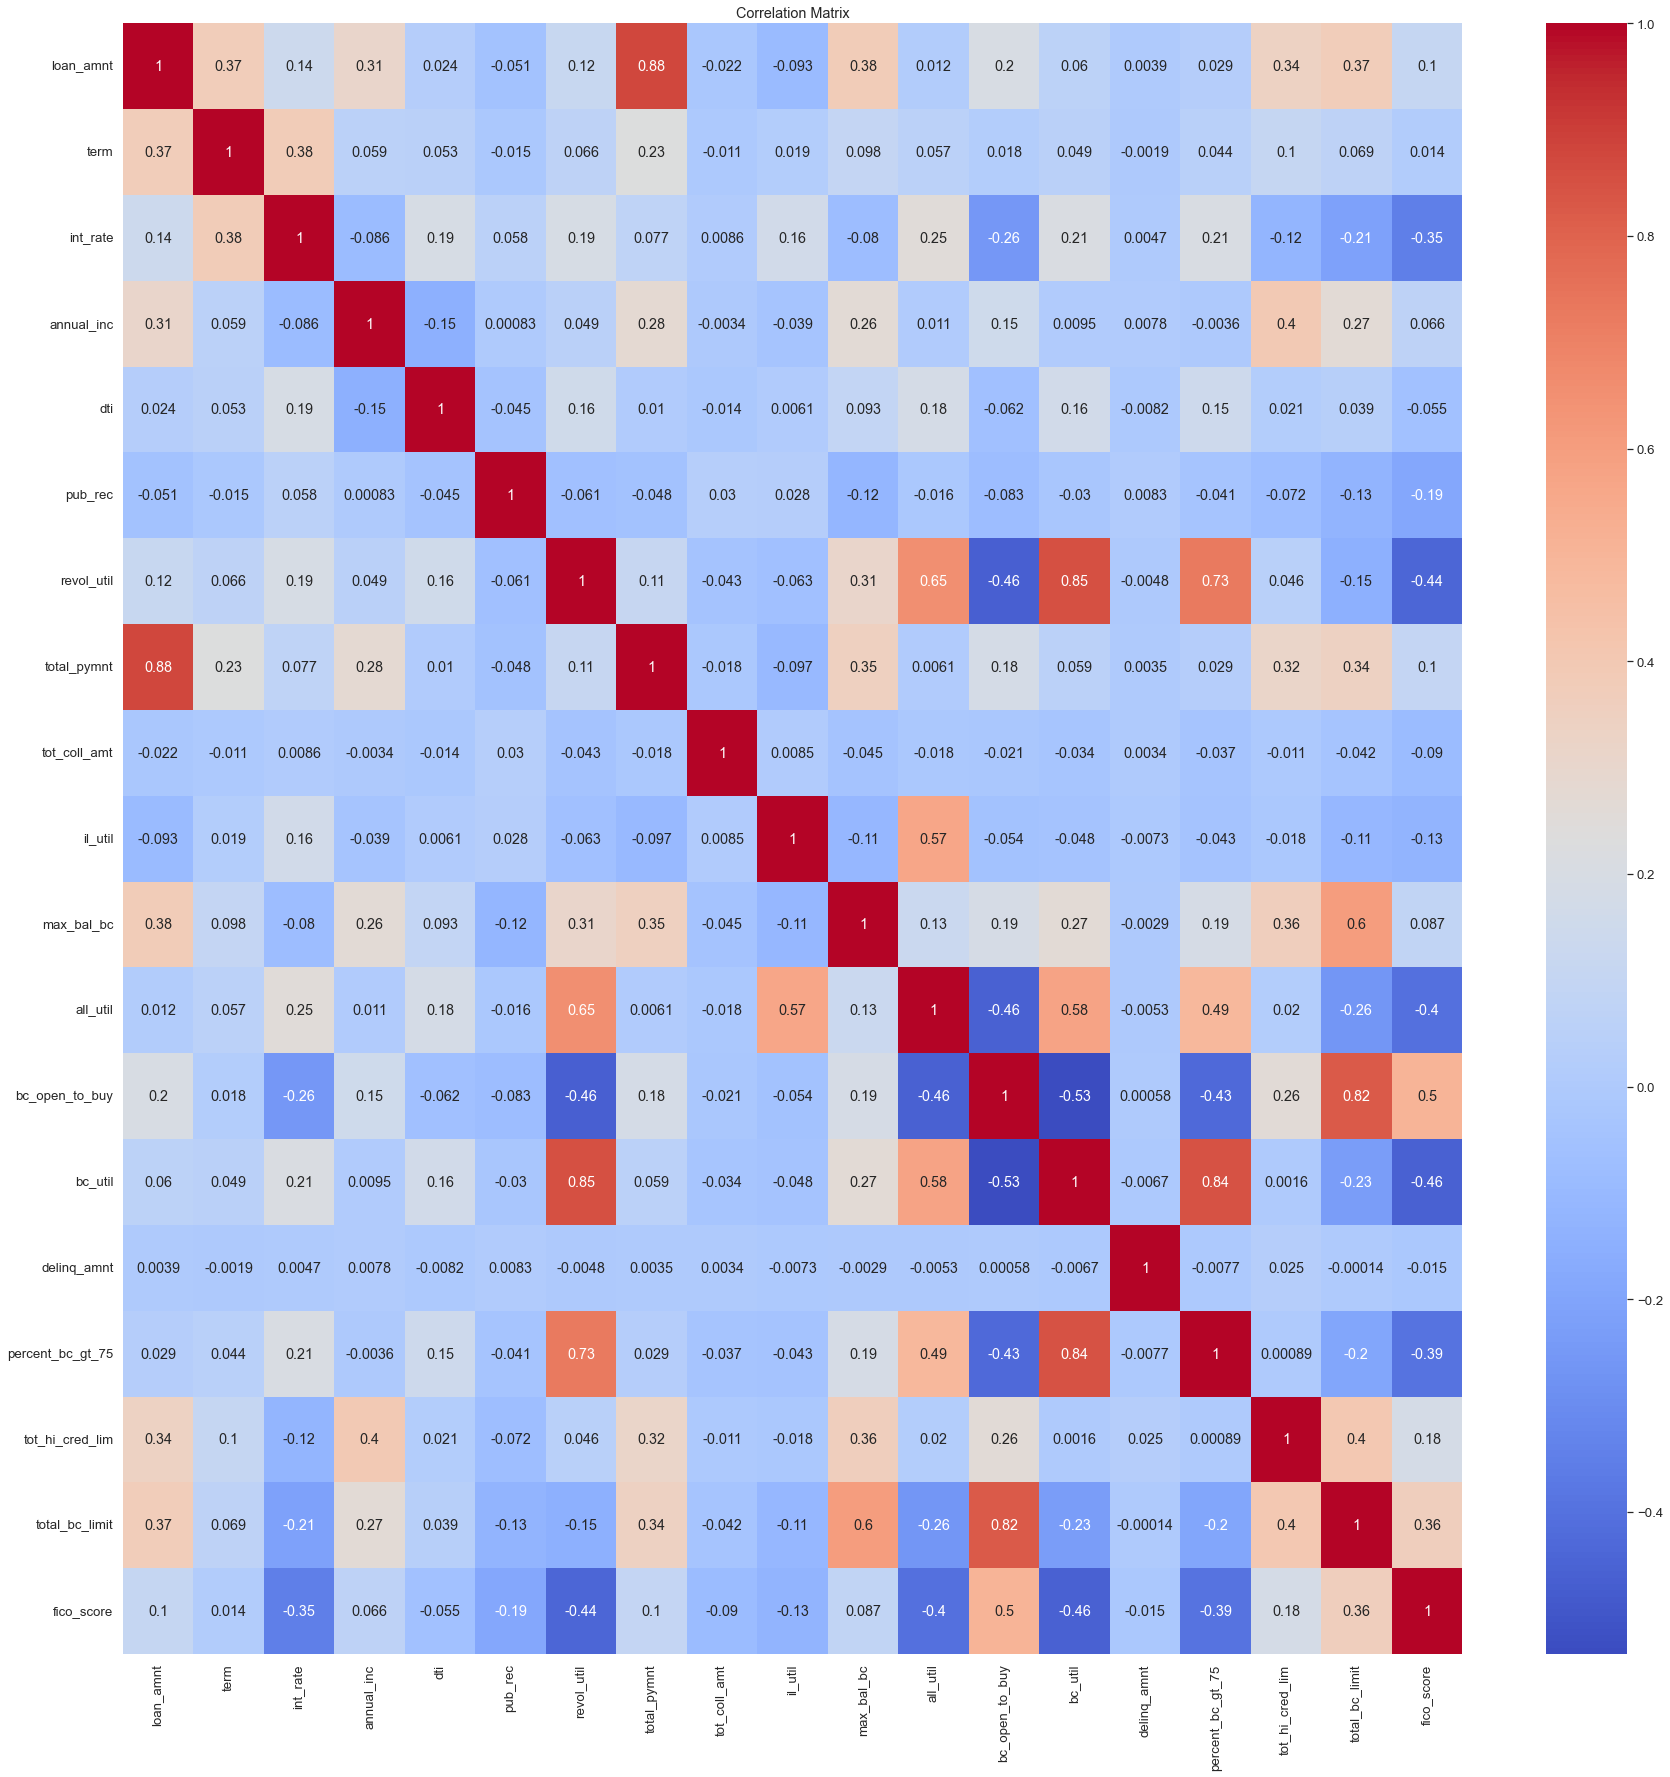

In [66]:
#Correlation Matrix
plt.figure(figsize=(30, 30))
corr_matrix = eda_df[eda_df.columns].corr()
corr_matrix[(corr_matrix > 0.5) | (corr_matrix < -0.5)] # keep only values > 0.5 or < -0.5
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')
plt.show()

In [67]:
model_df = eda_df

# Part 3
--------------

### Remove non matured loans

our model will be trained only on matured loans

In [68]:
model_df = model_df[(model_df['loan_status'] == 'Fully Paid') | (model_df['loan_status'] == 'Charged Off')]

in these loans 516 ~0.15% loans has no last payment date and therefore their annual realized return cannot be calculated. we will drop these loans

In [69]:
model_df = model_df[model_df['last_pymnt_d'].notna()]

In [70]:
model_df = model_df.drop(['last_pymnt_d','total_pymnt','months_passed'],axis=1)

## corr with target

In [71]:
model_df['ann_realized_return'] = model_df['ann_realized_return'].astype(float)

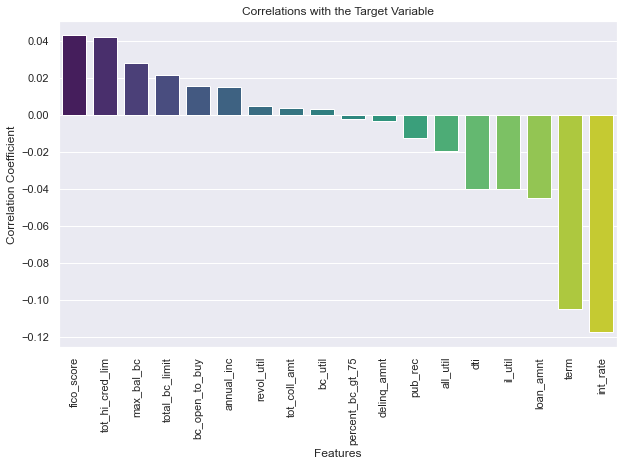

In [72]:
target_variable = 'ann_realized_return'
correlations = model_df.corr()[target_variable].sort_values(ascending=False)
correlations = correlations[1:]

# Set the figure size
sns.set(rc={'figure.figsize':(10, 6)})

# Create a bar chart using Seaborn
ax = sns.barplot(x=correlations.index, y=correlations, palette='viridis')

# Rotate the x-axis labels
plt.xticks(rotation=90)

# Set the title and labels
plt.title("Correlations with the Target Variable")
plt.xlabel("Features")
plt.ylabel("Correlation Coefficient")

# Display the plot
plt.show()

Remove columns with less the 0.005 correlation with the target variable

In [73]:
little_corr = list(correlations[abs(correlations) < 0.005].index)
print(little_corr)
#drop
model_df = model_df.drop(little_corr,axis=1)

['revol_util', 'tot_coll_amt', 'bc_util', 'percent_bc_gt_75', 'delinq_amnt']


# Categorical Features

### All uniq values for each column

In [74]:
model_df.columns
for col in model_df.columns:
    unique_values = model_df[col].unique()
    #print(col)
    # print(unique_values)

#### The categorial columns has left are :

- grade - <span style="color:green"> drop because represented in int_rate </span>
- sub_grade - <span style="color:green"> drop because represented in int_rate </span>
- term - <span style="color:green"> taking only 36 months loans, and then drop </span>
- emp_length - <span style="color:green"> drop  </span>
- home_ownership - <span style="color:green"> dummy variables </span>
- purpose - <span style="color:green"> dont know yet, later </span>
- application_type - <span style="color:green"> convert to binary 0 - Individual, 1 - Joint App </span>
- region - <span style="color:green"> dont know yet, later </span>

#### Copy of the df

In [75]:
model_df_copy = model_df.copy()

#### grade, sub_grade

In [76]:
from tabulate import tabulate

sub_grade_mapping = {
    'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5,
    'B1': 6, 'B2': 7, 'B3': 8, 'B4': 9, 'B5': 10,
    'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 'C5': 15,
    'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20,
    'E1': 21, 'E2': 22, 'E3': 23, 'E4': 24, 'E5': 25,
    'F1': 26, 'F2': 27, 'F3': 28, 'F4': 29, 'F5': 30,
    'G1': 31, 'G2': 32, 'G3': 33, 'G4': 34, 'G5': 35
}

grade_mapping = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7}

model_df_copy['sub_grade_numeric'] = model_df_copy['sub_grade'].map(sub_grade_mapping)
model_df_copy['grade_numeric'] = model_df_copy['grade'].map(grade_mapping)

corr_matrix = model_df_copy[['int_rate','grade_numeric','sub_grade_numeric']].corr()

# Print the correlation matrix as a table
print(tabulate(corr_matrix, headers='keys', tablefmt='fancy_grid', floatfmt=".2f"))

model_df_copy = model_df_copy.drop(['sub_grade', 'grade', 'sub_grade_numeric','grade_numeric'], axis=1)
model_df.drop(['sub_grade', 'grade'],axis=1,inplace=True)

╒═══════════════════╤════════════╤═════════════════╤═════════════════════╕
│                   │   int_rate │   grade_numeric │   sub_grade_numeric │
╞═══════════════════╪════════════╪═════════════════╪═════════════════════╡
│ int_rate          │       1.00 │            0.97 │                0.99 │
├───────────────────┼────────────┼─────────────────┼─────────────────────┤
│ grade_numeric     │       0.97 │            1.00 │                0.97 │
├───────────────────┼────────────┼─────────────────┼─────────────────────┤
│ sub_grade_numeric │       0.99 │            0.97 │                1.00 │
╘═══════════════════╧════════════╧═════════════════╧═════════════════════╛


#### term

In [77]:
model_df = model_df[model_df['term'] == 36]
model_df = model_df.drop('term', axis=1)

#### emp_length

In [78]:
# model_df_copy['emp_length'].unique()

# corr_matrix = model_df_copy[['emp_length', 'ann_realized_return']].corr()
# print(corr_matrix)

# corr_coef = np.corrcoef(model_df_copy['emp_length'], model_df_copy['ann_realized_return'])[0, 1]

# # Plot a scatter plot of emp_length vs ann_realized_return
# plt.scatter(model_df_copy['emp_length'], model_df_copy['ann_realized_return'])
# plt.xlabel('Employment Length')
# plt.ylabel('Annualized Realized Return')
# plt.title(f'Correlation coefficient: {corr_coef:.2f}')
# plt.show()

# we will leave it still

employment_lengths = {
    '< 1 year': 0.5,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10,
    0: 0
}

model_df['emp_length'] = model_df['emp_length'].map(employment_lengths)



#### home_ownership

In [79]:
model_df['home_ownership'].value_counts()

# Assuming your DataFrame is called "df"
dummies_home_ownership = pd.get_dummies(model_df['home_ownership'])

# Rename the columns to indicate the original category
dummies_home_ownership = dummies_home_ownership.rename(columns={
    'MORTGAGE': 'home_ownership_mortgage',
    'RENT': 'home_ownership_rent',
    'OWN': 'home_ownership_own',
    'ANY': 'home_ownership_any'
})

# Concatenate the dummy variables with the original DataFrame
model_df = pd.concat([model_df, dummies_home_ownership], axis=1)

# Drop the original categorical column
model_df = model_df.drop('home_ownership', axis=1)

#### application_type and initial_list_status

In [80]:
model_df['application_type'] = model_df['application_type'].replace({'Individual': 0,'Joint App': 1})
model_df['initial_list_status'] = model_df['initial_list_status'].replace({'w': 0,'f': 1})

### title
same as purpose

In [81]:
model_df.drop('title',axis=1,inplace=True)

### state

In [82]:
# we still don't know what is a proper way to group different states so its been removed by now
model_df.drop('addr_state', axis=1, inplace=True)

### purpose

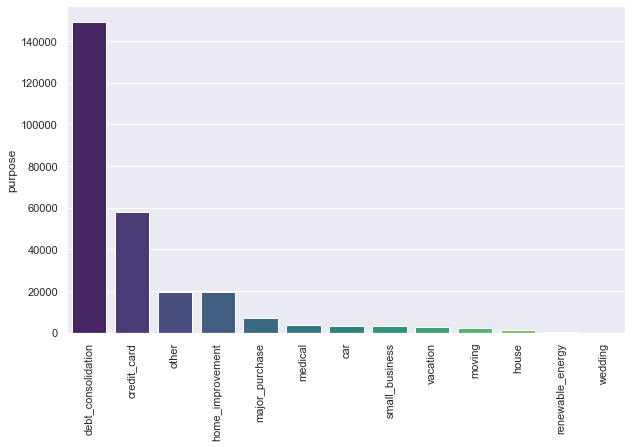

In [83]:
sns.barplot(x=model_df['purpose'].value_counts().index, y=model_df['purpose'].value_counts(), palette='viridis')
plt.xticks(rotation=90)
plt.show()

def purpose_class(text):
    if text=='debt_consolidation' or text=='credit_card':
        return 'refinance'
    elif text=='house' or text=='home_improvement' or text=='renewable_energy' or text=='moving':
        return 'home'
    elif text=='car' or text=='major_purchase':
        return 'major_purchase'
    else:
        return 'other'
    
model_df['purpose']= model_df['purpose'].apply(purpose_class)

# Assuming your DataFrame is called "df"
dummies_purpose = pd.get_dummies(model_df['purpose'])

# Rename the columns to indicate the original category
dummies_purpose = dummies_purpose.rename(columns={
    'refinance': 'purpose_refinance',
    'home': 'purpose_home',
    'major_purchase': 'purpose_major_purchase',
    'other': 'purpose_other'
})

# Concatenate the dummy variables with the original DataFrame
model_df = pd.concat([model_df, dummies_purpose], axis=1)

# Drop the original categorical column
model_df = model_df.drop('purpose', axis=1)

### Pub rec

In [84]:
model_df['pub_rec_binary'] = np.where(model_df['pub_rec'] > 0, 1, 0)
model_df.drop('pub_rec',axis=1,inplace=True)

### disbursement_method

In [85]:
model_df.drop('disbursement_method', axis =1, inplace=True)

### verifiction status

In [86]:
model_df['verification_status'].value_counts()

# it might be data leakage so we will drop it for now
model_df.drop('verification_status', axis =1, inplace=True)

# Numerical Feature

### annual income

remove outliers, loans with z score higher than 3

//// uri show qqplot and remove loans with z-score higher than 3////

(-50000.0, 450000.0)

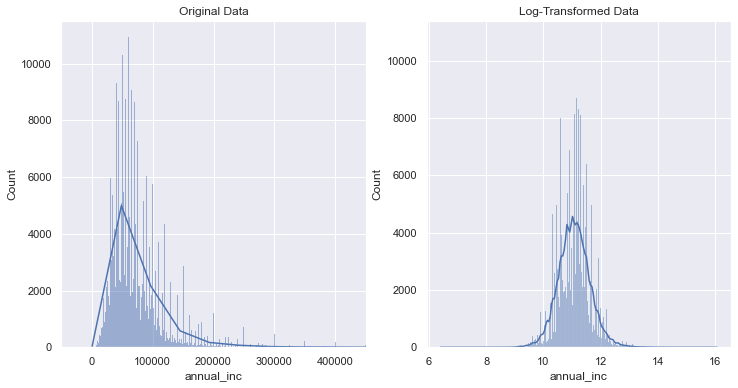

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(model_df['annual_inc'], ax=axs[0],kde=True)
axs[0].set_title('Original Data')
sns.histplot(np.log(model_df['annual_inc']), ax=axs[1],kde=True)
axs[1].set_title('Log-Transformed Data')
axs[0].set_xlim((-50000,4.5e5))
#plt.savefig('part 3/ann_income_dists.png')

Lower bound: 12114.057391958591
Upper bound: 346494.8970087503


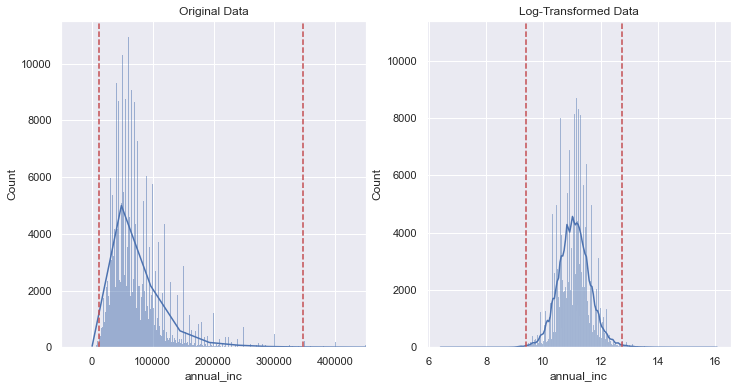

In [88]:
# Compute the quartiles and IQR of the 'annual_inc_log' feature
log_mean = np.log(model_df['annual_inc']).mean()
log_std = np.log(model_df['annual_inc']).std()

#on log
lower_bound_on_log = log_mean - 3 * log_std
upper_bound_on_log = log_mean + 3 * log_std

# Define the lower and upper bounds
lower_bound = np.exp(lower_bound_on_log)
upper_bound = np.exp(upper_bound_on_log )

# Print the lower and upper bounds
print('Lower bound:', lower_bound)
print('Upper bound:', upper_bound)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(model_df['annual_inc'], ax=axs[0],kde=True)
axs[0].set_title('Original Data')
sns.histplot(np.log(model_df['annual_inc']), ax=axs[1],kde=True)
axs[1].set_title('Log-Transformed Data')

axs[1].axvline(lower_bound_on_log, color='r', linestyle='--', label='Lower bound')
axs[1].axvline(upper_bound_on_log, color='r', linestyle='--', label='Upper bound')
axs[0].axvline(lower_bound, color='r', linestyle='--', label='Lower bound')
axs[0].axvline(upper_bound, color='r', linestyle='--', label='Upper bound')

# ax.legend()
axs[0].set_xlim((-50000,4.5e5))
plt.show()

#Create a kernel density plot of the original and log-transformed data
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# sns.kdeplot(aaa['annual_inc'], ax=axs[0])
# axs[0].set_title('Original Data')
# sns.kdeplot(np.log(aaa['annual_inc']), ax=axs[1])
# axs[1].set_title('Log-Transformed Data')
# plt.show()

In [89]:
ann_income_n_outliers = ((model_df['annual_inc'] < lower_bound) | (model_df['annual_inc'] > upper_bound)).sum()
ann_income_pct_outliers =  100* ann_income_n_outliers / len(model_df)



results_df = pd.DataFrame({
    'lower_bound': [round(lower_bound)],
    'upper_bound': [round(upper_bound)],
    '# outliers': [ann_income_n_outliers],
    '% outliers': [round(ann_income_pct_outliers,3)]
}, index=['annual_inc'])

# Display the results
display(results_df)

,lower_bound,upper_bound,# outliers,% outliers
annual_inc,12114,346495,2187,0.813


In [90]:
# filter outliers
model_df = model_df[((model_df['annual_inc']) >= lower_bound) & ((model_df['annual_inc']) <= upper_bound)]


In [91]:
# log transformation
model_df.loc[:, 'annual_inc'] = np.log(model_df['annual_inc'])

### loan amount

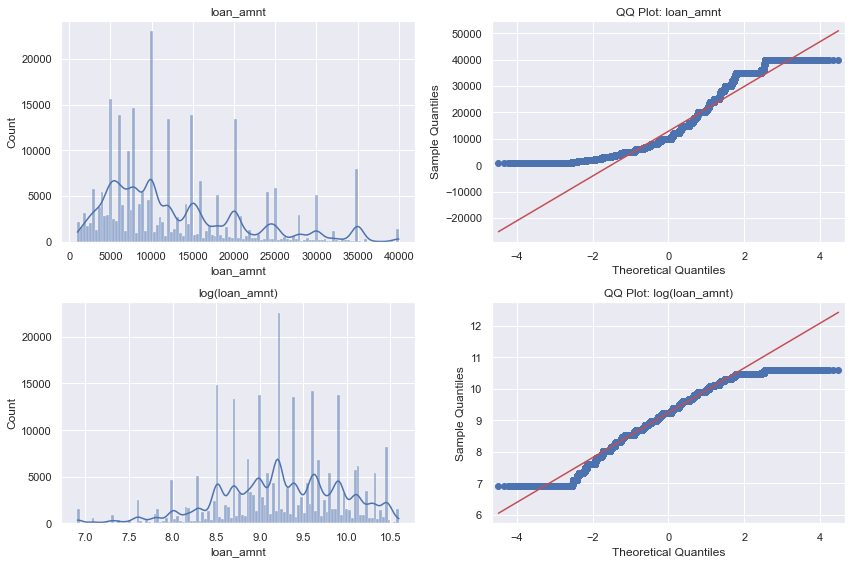

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot histogram
# sns.histplot(data=model_df, x='loan_amnt', kde=True, ax=axes[0])

# # Plot QQ plot
# sm.qqplot(np.log(model_df['loan_amnt']), line='s', ax=axes[1])

axes[0, 0].set_title('loan_amnt')
sns.histplot(data=model_df, x='loan_amnt', kde=True, ax=axes[0,0])

# QQ plot of model_df['loan_amnt']
axes[0, 1].set_title('QQ Plot: loan_amnt')
sm.qqplot(model_df['loan_amnt'], line='s', ax=axes[0,1])

# Plot histogram and QQ plot for np.log(model_df['loan_amnt'])
# Histogram of np.log(model_df['loan_amnt'])
axes[1, 0].set_title('log(loan_amnt)')
sns.histplot(x=np.log(model_df['loan_amnt']),kde=True, ax=axes[1, 0])

# QQ plot of np.log(model_df['loan_amnt'])
axes[1, 1].set_title('QQ Plot: log(loan_amnt)')
sm.qqplot(np.log(model_df['loan_amnt']), line='s', ax=axes[1,1])

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.savefig('part 3/loan amnt dist')
plt.tight_layout()
plt.show()









In [93]:
model_df.loc[:, 'loan_amnt'] = np.log(model_df['loan_amnt'])

### dti

we can see that after we removed outliers from annaul_income
the dti is almost normal therefore we will remove

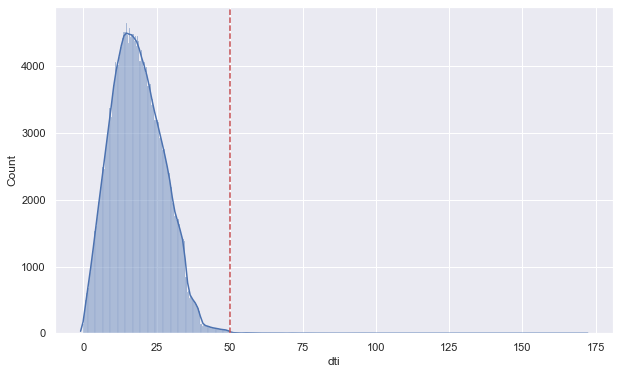

In [94]:
sns.histplot(model_df['dti'],kde=True)
plt.axvline(x=50, color='r',linestyle='--')
plt.show()

In [95]:
dti_num_outliers = len(model_df.loc[model_df['dti'] > 50])
dti_pct_outliers = dti_num_outliers / len(model_df) * 100

results_df = pd.DataFrame({
    'lower_bound': [0],
    'upper_bound': [50],
    '# outliers': [dti_num_outliers],
    '% outliers': [round(dti_pct_outliers,3)]
}, index=['dti'])

display(results_df)

,lower_bound,upper_bound,# outliers,% outliers
dti,0,50,259,0.097


In [96]:
# filter dti outliers
model_df = model_df[model_df['dti'] <= 50]

dti after removing outliers

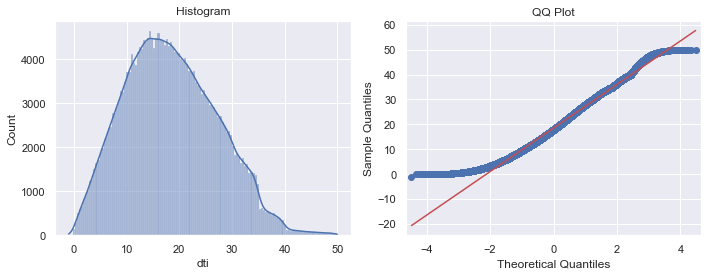

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot histogram
sns.histplot(data=model_df, x='dti', kde=True, ax=axes[0])
axes[0].set_xlabel('dti')
axes[0].set_ylabel('Count')
axes[0].set_title('Histogram')

# Plot QQ plot
sm.qqplot(model_df['dti'], line='s', ax=axes[1])
axes[1].set_xlabel('Theoretical Quantiles')
axes[1].set_ylabel('Sample Quantiles')
axes[1].set_title('QQ Plot')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
#plt.savefig('part 3/dti_after_removing_outliers.png')
plt.show()



### fico


<AxesSubplot:xlabel='fico_score', ylabel='Count'>

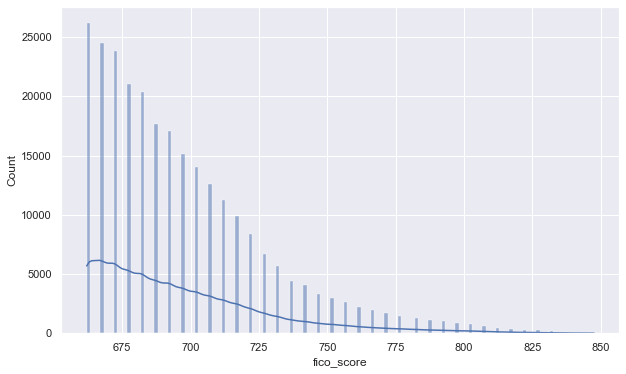

In [98]:
sns.histplot(x=((model_df['fico_score'])),kde=True)
#plt.savefig('part 3/fico_score_dist')

In [99]:
model_df.loc[:, 'fico_score'] = np.log(model_df['fico_score'])

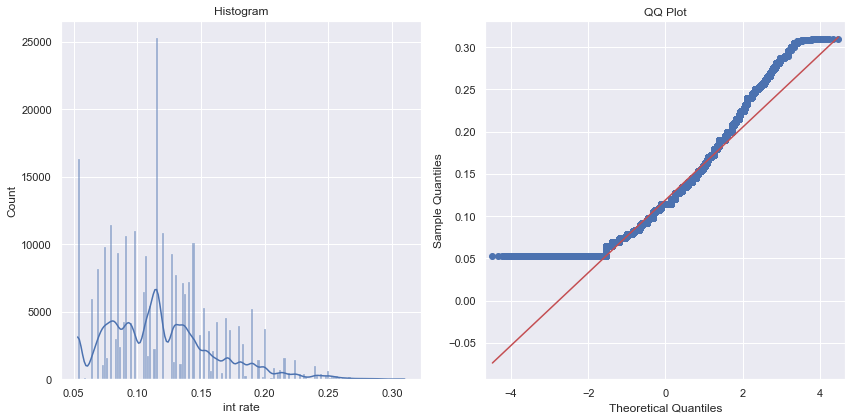

In [100]:

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram
sns.histplot(data=model_df, x='int_rate', kde=True, ax=axes[0])
axes[0].set_xlabel('int rate')
axes[0].set_ylabel('Count')
axes[0].set_title('Histogram')

# Plot QQ plot
sm.qqplot(model_df['int_rate'], line='s', ax=axes[1])
axes[1].set_xlabel('Theoretical Quantiles')
axes[1].set_ylabel('Sample Quantiles')
axes[1].set_title('QQ Plot')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
#plt.savefig('part 3/int_rate dist')
plt.show()


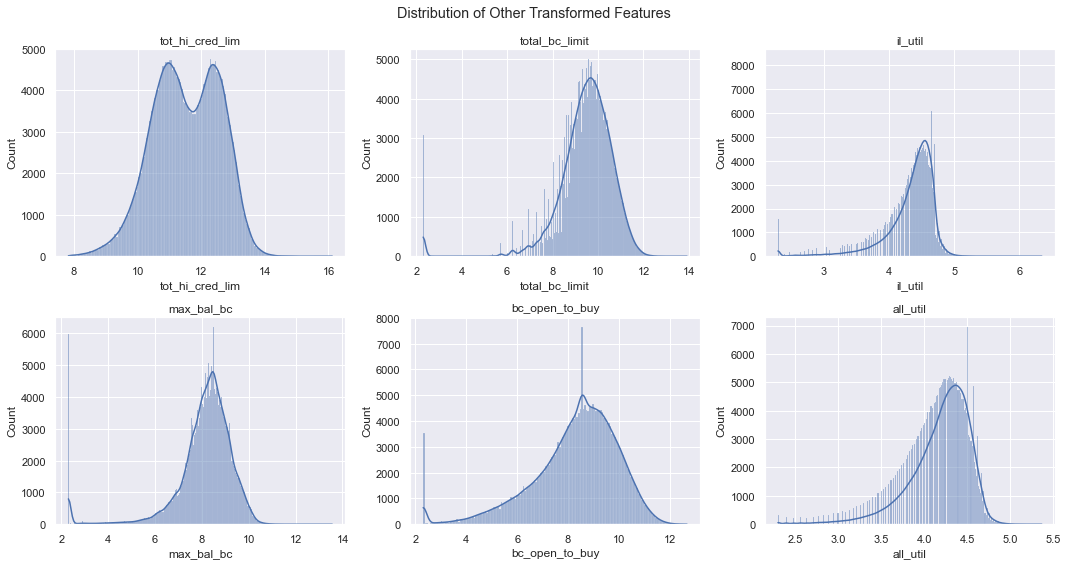

In [101]:
columns = ['tot_hi_cred_lim', 'total_bc_limit', 'il_util', 'max_bal_bc', 'bc_open_to_buy', 'all_util']
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, column in enumerate(columns):
    row = i // 3
    col = i % 3
    sns.histplot(np.log(model_df[column]+10), ax=axes[row, col], kde=True)
    axes[row, col].set_title(column)

fig.suptitle("Distribution of Other Transformed Features")
#plt.savefig('part 3/Distribution of Other Transformed Features')
plt.tight_layout()
plt.show()
    



In [102]:
# we added 10 which is small number compared to the mean in order to handle 0 values

columns = ['tot_hi_cred_lim', 'total_bc_limit', 'il_util', 'max_bal_bc', 'bc_open_to_buy', 'all_util']
for column in columns:
    model_df[column] = np.log(model_df[column]+10)

# Dates

###  issue date

In [103]:
model_df = model_df.drop('issue_d', axis =1)

### loan status

In [104]:
model_df = model_df.drop('loan_status', axis =1)

rearange

In [105]:
model_df = model_df[['loan_amnt', 'int_rate', 'emp_length', 'annual_inc', 'dti',
       'initial_list_status', 'application_type', 'il_util', 'max_bal_bc',
       'all_util', 'bc_open_to_buy', 'tot_hi_cred_lim', 'total_bc_limit',
       'fico_score', 'home_ownership_any',
       'home_ownership_mortgage', 'home_ownership_own', 'home_ownership_rent',
       'purpose_home', 'purpose_major_purchase', 'purpose_other',
       'purpose_refinance', 'pub_rec_binary', 'ann_realized_return']]

## Dummies and scaling

In [106]:
final_model_df = model_df

### Splitting the data into train and test

In [107]:
from sklearn.model_selection import train_test_split

# Separate the features and the target variable
X = final_model_df.drop('ann_realized_return', axis=1)
y = final_model_df['ann_realized_return']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [108]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Define the columns to be scaled
columns_to_scale = ['loan_amnt', 'int_rate', 'emp_length', 'annual_inc', 'dti', 'fico_score',
                   'il_util', 'max_bal_bc', 'all_util', 'bc_open_to_buy', 'tot_hi_cred_lim', 'total_bc_limit',]

# Fit the scaler on X_train and transform X_train
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

# Transform X_test using the fitted scaler from X_train
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
